# Homework 5
## Jesse Ellin
## CNNs, AEs, GANs

### Task 1
Data source : https://data.mendeley.com/datasets/5y9wdsg2zt/2

I will be classifying images of concrete to determine if the concrete is damaged or not. This task is particularly interesting to me since a heavily-used bridge in my hometown had a major crack found in the main support column that had gone undetected for years. If we can train a computer vision network to detect damage in concrete, then potentially we can have passive monitoring on these significant arterials to catch risks before they're problematic.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
CUDA = len(tf.config.list_physical_devices("GPU")) > 0
import gc
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns
import time

from IPython import display

In [2]:
CUDA

True

In [3]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

DataLoaders (now outdated but felt too painful deleting this)

In [4]:
class Dataset():
    def __init__(self, img_dir, label):
        self.label = label
        self.img_dir = img_dir
        self.len = len(os.listdir(img_dir))
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_name = f"{self.img_dir}/{os.listdir(self.img_dir)[idx]}"
        img = tf.keras.utils.load_img(img_name)
        return {"image" : np.array(img.getdata()).reshape(img.size[0], img.size[1], 3), "label" : self.label}

class CombinedDataset():
    def __init__(self, datasets, t=False):
        self.datasets = datasets
        self.lens = [len(dataset) for dataset in datasets]
        self.t = t
    
    def __len__(self):
        return sum(self.lens)
    
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            items = [ii for ii in range(idx.start, idx.stop, idx.step)]
            return self[items]
        if type(idx) is list:
            if self.t:
                idx = tqdm(idx, leave=False)
            items = [self.__getitem__(i) for i in idx]
            return {"image" : np.array([i["image"] for i in items]), "label" : np.array([i["label"] for i in items])}
        running_len = 0
        for i, l in enumerate(self.lens):
            running_len += l
            if idx < running_len:
                return self.datasets[i][idx - running_len]

In [5]:
true_data = Dataset("task1_data/Positive", True)

In [6]:
false_data = Dataset("task1_data/Negative", False)

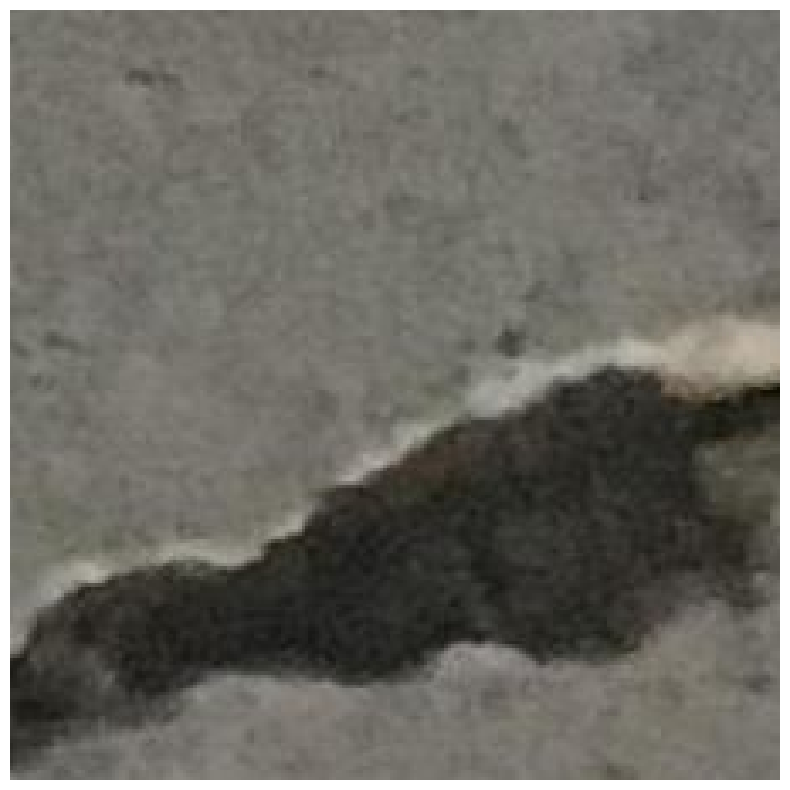

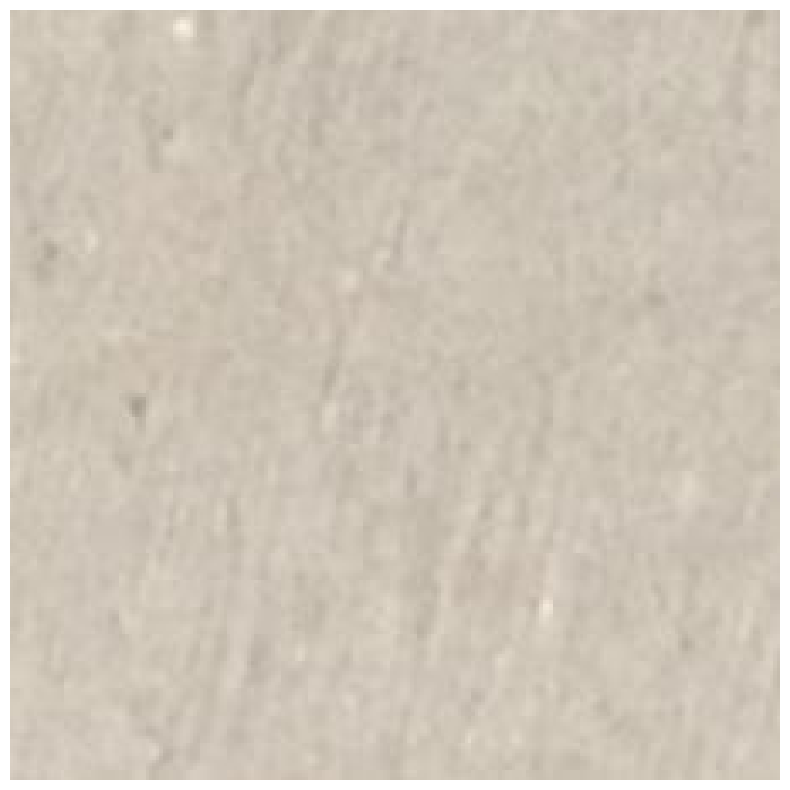

In [7]:
visualize(true_data[1]["image"])
visualize(false_data[1]["image"])

In [8]:
all_data = CombinedDataset([true_data, false_data], t=True)

#### Part 1

In [9]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_batch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [10]:
class CNN():
    def __init__(self, img_shape, **kwargs):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation=None, input_shape=img_shape),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), activation=None),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), activation=None),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation=None),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
        
        print(self.model.summary())
        self.model.compile(**kwargs)
    
    def train(self, X_ds, **kwargs):
        return self.model.fit(X_ds, **kwargs)
    
    def __call__(self, X, **kwargs):
        return self.model(X, **kwargs)

In [11]:
cnn_model = CNN(true_data[0]["image"].shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-7), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"], run_eagerly=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 225, 225, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 110, 110, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                    

In [12]:
batch_size = 128
train_dl, val_dl = tf.keras.utils.image_dataset_from_directory("task1_data", labels="inferred", label_mode="binary", batch_size=batch_size, image_size=true_data[0]["image"].shape[:2], shuffle=True, validation_split=0.2, subset="both", seed=42)

Found 39985 files belonging to 2 classes.
Using 31988 files for training.
Using 7997 files for validation.


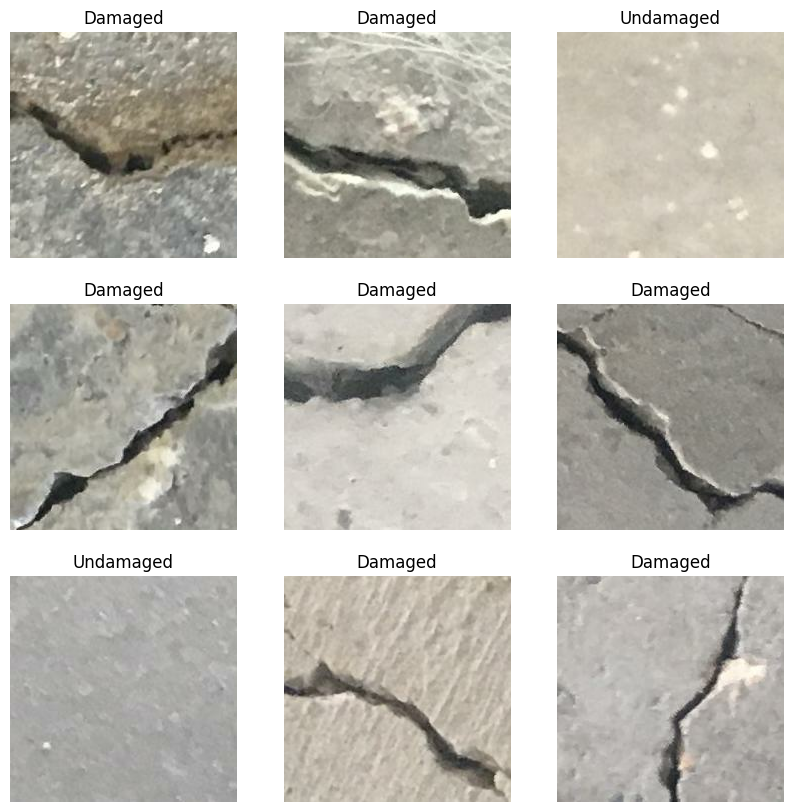

In [13]:
plt.figure(figsize=(10,10))
for images, labels in train_dl.take(1):
    for i in range(9):
        l = "Damaged" if labels[i] == 1 else "Undamaged"
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(l)
        plt.axis("off")

In [14]:
epochs = 100
cm = ClearMemory()
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
cnn_model.train(train_dl, validation_data=val_dl, epochs=epochs, callbacks=[cm, es])

Epoch 1/100
250/250 [==============================] - 132s 496ms/step - loss: 70.2959 - accuracy: 0.7424 - val_loss: 0.7789 - val_accuracy: 0.7795
Epoch 2/100
250/250 [==============================] - 122s 480ms/step - loss: 2.5320 - accuracy: 0.8609 - val_loss: 17.9686 - val_accuracy: 0.4962
Epoch 3/100
250/250 [==============================] - 117s 462ms/step - loss: 1.2594 - accuracy: 0.8996 - val_loss: 0.0840 - val_accuracy: 0.9800
Epoch 4/100
250/250 [==============================] - 122s 483ms/step - loss: 16.3248 - accuracy: 0.9277 - val_loss: 4.6570 - val_accuracy: 0.7875
Epoch 5/100
250/250 [==============================] - 121s 480ms/step - loss: 3.7182 - accuracy: 0.9147 - val_loss: 0.3708 - val_accuracy: 0.9675
Epoch 6/100
250/250 [==============================] - 122s 481ms/step - loss: 6.8089 - accuracy: 0.8821 - val_loss: 0.4083 - val_accuracy: 0.9664


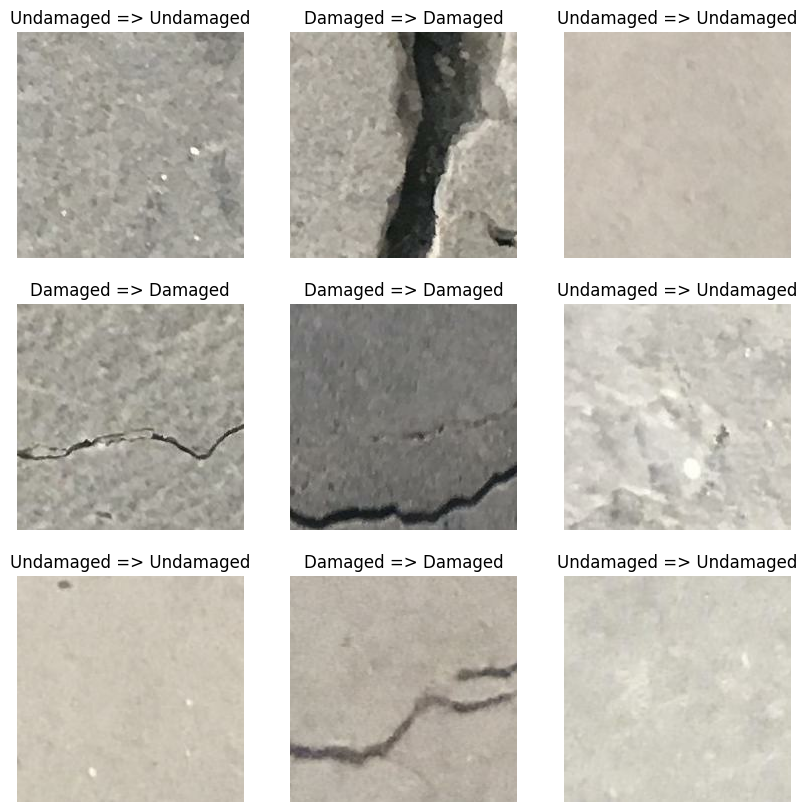

In [15]:
plt.figure(figsize=(10,10))
for images, labels in val_dl.take(1):
    for i in range(9):
        true_label = "Damaged" if labels[i] == True else "Undamaged"
        prediction = cnn_model(np.array([images[i]]))
        pred_label = "Damaged" if prediction >= 0.5 else "Undamaged"
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{true_label} => {pred_label}")
        plt.axis("off")

  0%|          | 0/25 [00:00<?, ?it/s]

Pulled 61 images


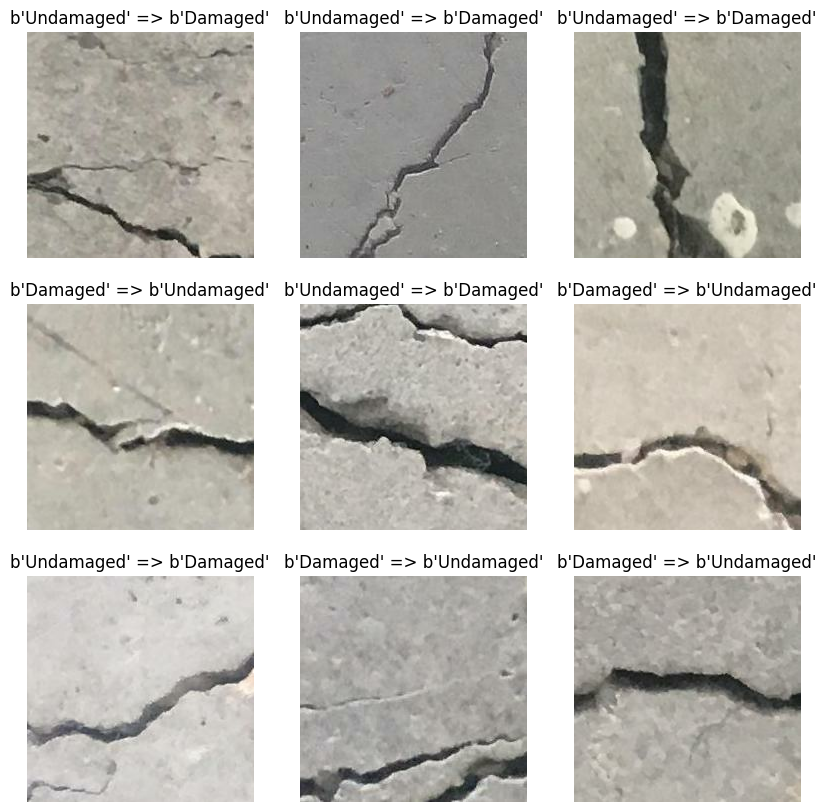

In [16]:
plt.figure(figsize=(10,10))
all_images = []
all_labels = []
for images, labels in tqdm(val_dl.take(25)):
    predictions = cnn_model(images)
    predictions = tf.where(predictions >= 0.5, 1., 0.)
    ids = tf.where(predictions != labels)
    for i in ids:
        all_labels.append(labels[i[0]])
        all_images.append(images[i[0]])

print(f"Pulled {len(all_images)} images")
i = 0
predictions = tf.where(cnn_model(np.array(all_images)) >= 0.5, "Damaged", "Undamaged")
labels = tf.where(np.array(all_labels) == 1., "Damaged", "Undamaged")
while i < 9:
    if labels[i] == predictions[i]:
        continue
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{labels[i][0]} => {predictions[i][0]}")
    plt.axis("off")
    i += 1

In [17]:
y_pred = None
all_labels = None
for images, labels in val_dl:
    if type(all_labels) == type(None):
        all_labels = labels
    else:
        all_labels = np.vstack((all_labels, labels))

    preds = cnn_model(images)
    if type(y_pred) == type(None):
        y_pred = preds
    else:
        y_pred = np.vstack((y_pred, preds))

In [18]:
all_labels = tf.where(all_labels == 1., True, False)
y_pred = tf.where(y_pred >= 0.5, True, False)

In [19]:
cf_matrix = sklearn.metrics.confusion_matrix(all_labels, y_pred)

<AxesSubplot: >

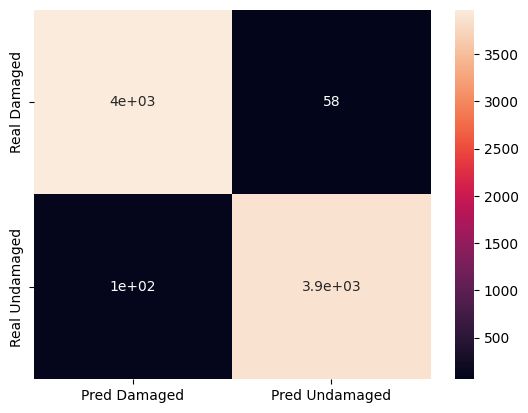

In [20]:
sns.heatmap(cf_matrix, annot=True, xticklabels=["Pred Damaged", "Pred Undamaged"], yticklabels=["Real Damaged", "Real Undamaged"])

#### Part 2
Pre-trained InceptionV3 network

This model performed significantly better than my model did. I believe this is due to the complexity of the InceptionV3 network and it being trained on a much larger and more diverse image set, allowing it to select more dynamic features.

In [21]:
# Transfer in model without top-layer so we can retrain a classifier over a feature extractor
inception_v3 = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=true_data[0]["image"].shape, classes=2, classifier_activation="sigmoid")

In [22]:
inception_v3.trainable = False

In [23]:
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [24]:
class TransferedModel:
    def __init__(self, base_model, input_shape, **kwargs):
        self.model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape),
            base_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
        print(self.model.summary())
        self.model.compile(**kwargs)
    
    def train(self, X_ds, **kwargs):
        return self.model.fit(X_ds, **kwargs)
    
    def __call__(self, X, **kwargs):
        return self.model(X, **kwargs)

In [25]:
transfered_model = TransferedModel(inception_v3, true_data[0]["image"].shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-7), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"], run_eagerly=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [26]:
epochs = 100
cm = ClearMemory()
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
transfered_model.train(train_dl, validation_data=val_dl, epochs=epochs, callbacks=[cm, es])

Epoch 1/100
250/250 [==============================] - 239s 913ms/step - loss: 3.0477 - accuracy: 0.9591 - val_loss: 0.5333 - val_accuracy: 0.9876
Epoch 2/100
250/250 [==============================] - 216s 858ms/step - loss: 1.4867 - accuracy: 0.9771 - val_loss: 1.0041 - val_accuracy: 0.9720
Epoch 3/100
250/250 [==============================] - 216s 858ms/step - loss: 1.4893 - accuracy: 0.9802 - val_loss: 3.6480 - val_accuracy: 0.9148
Epoch 4/100
250/250 [==============================] - 215s 857ms/step - loss: 1.1560 - accuracy: 0.9822 - val_loss: 0.6368 - val_accuracy: 0.9907


  0%|          | 0/25 [00:00<?, ?it/s]

Pulled 39 images


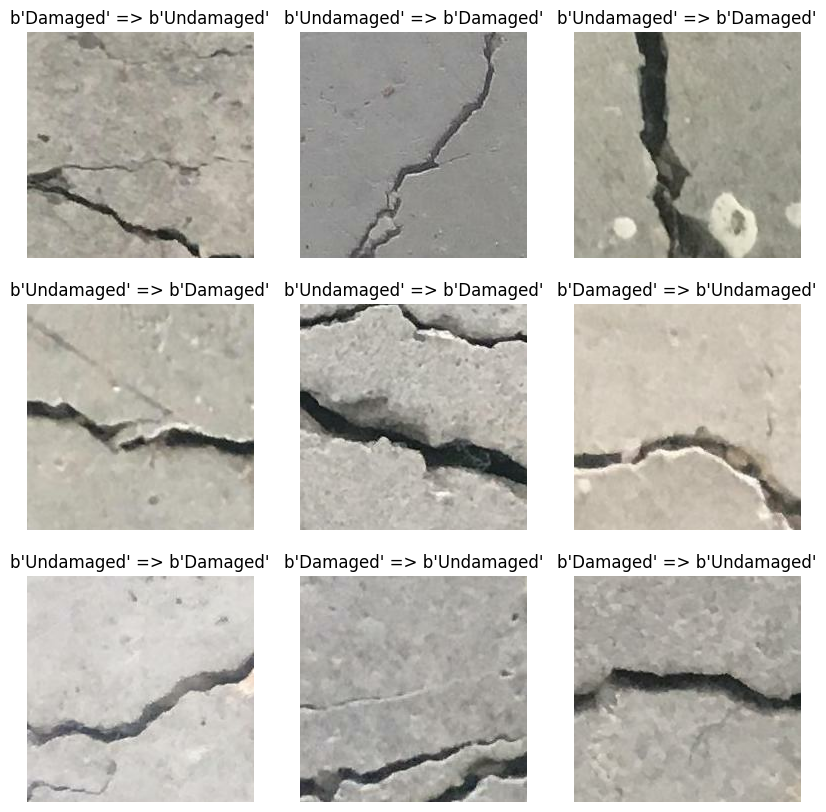

In [27]:
plt.figure(figsize=(10,10))
all_images = []
all_labels = []
for images, labels in tqdm(val_dl.take(25)):
    predictions = transfered_model(images)
    predictions = tf.where(predictions >= 0.5, 1., 0.)
    ids = tf.where(predictions != labels)
    for i in ids:
        all_labels.append(labels[i[0]])
        all_images.append(images[i[0]])

print(f"Pulled {len(all_images)} images")
i = 0
predictions = tf.where(transfered_model(np.array(all_images)) >= 0.5, "Damaged", "Undamaged")
labels = tf.where(np.array(all_labels) == 1., "Damaged", "Undamaged")
while i < 9:
    if labels[i] == predictions[i]:
        continue
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{labels[i][0]} => {predictions[i][0]}")
    plt.axis("off")
    i += 1

In [28]:
y_pred = None
all_labels = None
for images, labels in tqdm(val_dl):
    if type(all_labels) == type(None):
        all_labels = labels
    else:
        all_labels = np.vstack((all_labels, labels))

    preds = transfered_model(images)
    if type(y_pred) == type(None):
        y_pred = preds
    else:
        y_pred = np.vstack((y_pred, preds))

  0%|          | 0/63 [00:00<?, ?it/s]

In [29]:
all_labels = tf.where(all_labels == 1., True, False)
y_pred = tf.where(y_pred >= 0.5, True, False)

In [30]:
cf_matrix = sklearn.metrics.confusion_matrix(all_labels, y_pred)

<AxesSubplot: >

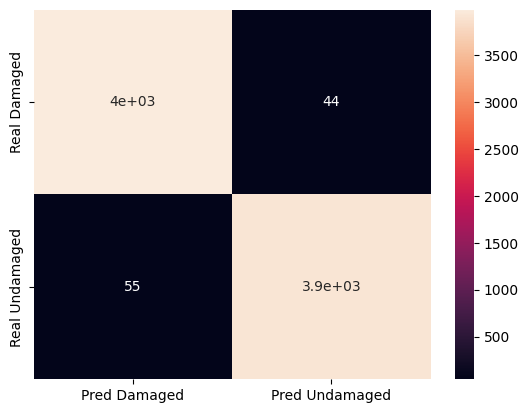

In [31]:
sns.heatmap(cf_matrix, annot=True, xticklabels=["Pred Damaged", "Pred Undamaged"], yticklabels=["Real Damaged", "Real Undamaged"])

#### Part 3
Based on these results, it seems clear that image augmentation did not improve performance. I believe this is caused by the fine detail in the original images and how the transformations may impact the small features the model picks up on

In [44]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    dtype=int,
    validation_split=0.2
)
# image_gen.fit(all_data[0:len(all_data)//100:1]["image"])

In [45]:
train_image_generator = image_gen.flow_from_directory(
    "task1_data",
    target_size=(227,227),
    batch_size=batch_size,
    class_mode="binary"   ,
    seed=42,
    subset="training",
    interpolation="lanczos"
)
val_image_generator = image_gen.flow_from_directory(
    "task1_data",
    target_size=(227,227),
    batch_size=batch_size,
    class_mode="binary"   ,
    seed=42,
    subset="validation",
    interpolation="lanczos"
)

Found 31988 images belonging to 2 classes.
Found 7997 images belonging to 2 classes.


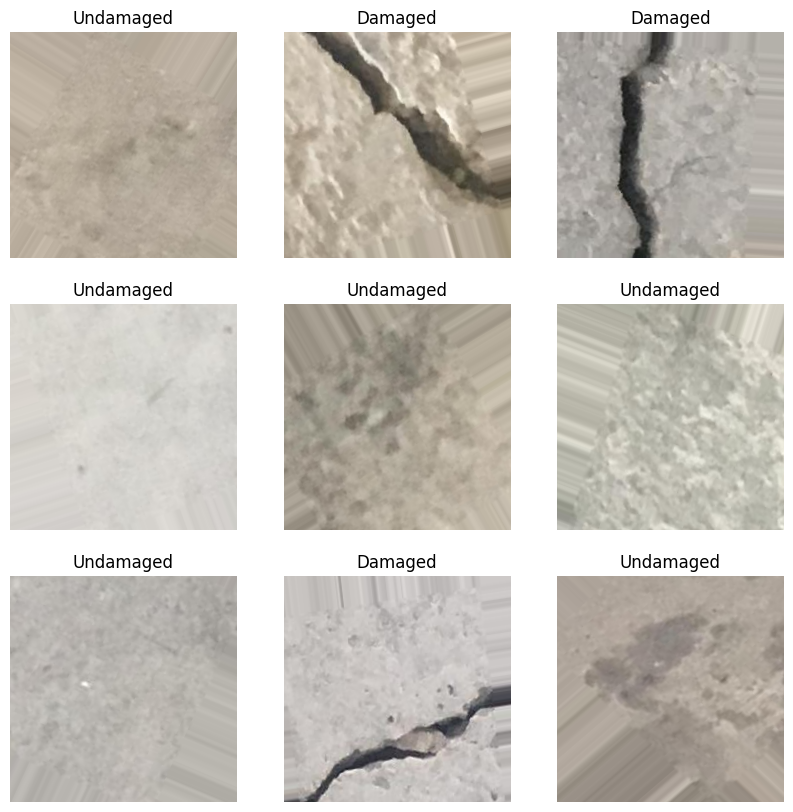

In [46]:
images, labels = next(train_image_generator)
labels = np.where(labels == 1, "Damaged", "Undamaged")
plt.figure(figsize=(10,10))
for i, im in enumerate(images[:9]):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(im)
    plt.title(labels[i])
    plt.axis("off")

In [47]:
aug_model = CNN(true_data[0]["image"].shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-7), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"], run_eagerly=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 225, 225, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 110, 110, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                    

In [48]:
epochs = 100
cm = ClearMemory()
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
aug_model.train(train_image_generator, validation_data=val_image_generator, epochs=epochs, callbacks=[cm, es])

Epoch 1/100
250/250 [==============================] - 467s 2s/step - loss: 45.4311 - accuracy: 0.6956 - val_loss: 0.1226 - val_accuracy: 0.9570
Epoch 2/100
250/250 [==============================] - 464s 2s/step - loss: 2.3988 - accuracy: 0.7753 - val_loss: 0.1489 - val_accuracy: 0.9552
Epoch 3/100
250/250 [==============================] - 471s 2s/step - loss: 0.1676 - accuracy: 0.9556 - val_loss: 0.1122 - val_accuracy: 0.9729
Epoch 4/100
250/250 [==============================] - 464s 2s/step - loss: 10.8067 - accuracy: 0.7650 - val_loss: 0.4983 - val_accuracy: 0.8438
Epoch 5/100
250/250 [==============================] - 457s 2s/step - loss: 0.8558 - accuracy: 0.8969 - val_loss: 0.1544 - val_accuracy: 0.9516
Epoch 6/100
250/250 [==============================] - 482s 2s/step - loss: 0.1658 - accuracy: 0.9546 - val_loss: 0.0988 - val_accuracy: 0.9715
Epoch 7/100
250/250 [==============================] - 467s 2s/step - loss: 17.1942 - accuracy: 0.7643 - val_loss: 1.1944 - val_accura

In [49]:
y_pred = None
all_labels = None
for images, labels in tqdm(val_dl):
    if type(all_labels) == type(None):
        all_labels = labels
    else:
        all_labels = np.vstack((all_labels, labels))

    preds = aug_model(images)
    if type(y_pred) == type(None):
        y_pred = preds
    else:
        y_pred = np.vstack((y_pred, preds))

  0%|          | 0/63 [00:00<?, ?it/s]

In [50]:
all_labels = tf.where(all_labels == 1., True, False)
y_pred = tf.where(y_pred >= 0.5, True, False)

In [51]:
cf_matrix = sklearn.metrics.confusion_matrix(all_labels, y_pred)

<AxesSubplot: >

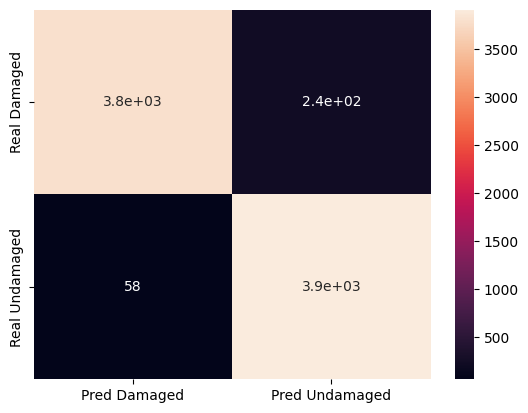

In [52]:
sns.heatmap(cf_matrix, annot=True, xticklabels=["Pred Damaged", "Pred Undamaged"], yticklabels=["Real Damaged", "Real Undamaged"])

  0%|          | 0/25 [00:00<?, ?it/s]

Pulled 133 images


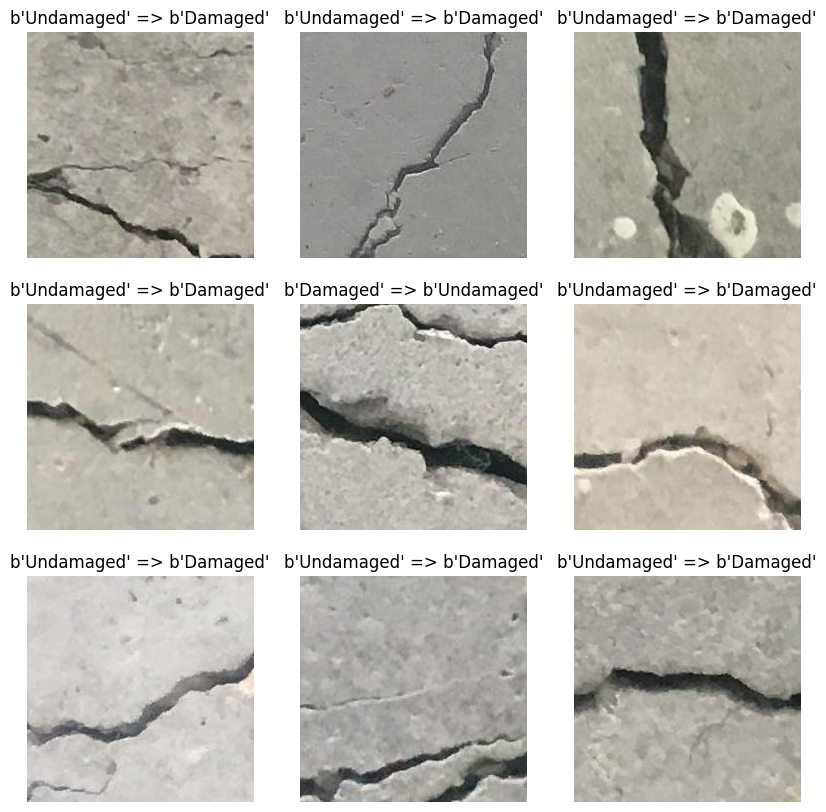

In [54]:
plt.figure(figsize=(10,10))
all_images = []
all_labels = []
for images, labels in tqdm(val_dl.take(25)):
    predictions = aug_model(images)
    predictions = tf.where(predictions >= 0.5, 1., 0.)
    ids = tf.where(predictions != labels)
    for i in ids:
        all_labels.append(labels[i[0]])
        all_images.append(images[i[0]])

print(f"Pulled {len(all_images)} images")
i = 0
predictions = tf.where(aug_model(np.array(all_images)) >= 0.5, "Damaged", "Undamaged")
labels = tf.where(np.array(all_labels) == 1., "Damaged", "Undamaged")
while i < 9:
    if labels[i] == predictions[i]:
        continue
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{labels[i][0]} => {predictions[i][0]}")
    plt.axis("off")
    i += 1

### Task 2
Data source : https://www.kaggle.com/datasets/gpiosenka/100-bird-species?select=train

This dataset contains 76000 training images (data I will be using) of 450 bird species.

(NOTE: In running this dataset through a deep VAE, the elbo loss continued to exploded to nan. Was not able to debug, so switched to Fashion MNIST. It seems this data is too complex for the models my computer can handle)

In [55]:
bird_batch_size = 32
task2_train_dl, task2_val_dl = tf.keras.utils.image_dataset_from_directory("task2_data/train", labels="inferred", batch_size=bird_batch_size, image_size=(224,224), shuffle=True, validation_split=0.2, subset="both", seed=42)

Found 70626 files belonging to 450 classes.
Using 56501 files for training.
Using 14125 files for validation.


#### Part 1

In [74]:
class CVAE(tf.keras.Model):
    def __init__(self, input_shape, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        kernel_initializer="normal" # tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer="zeros" # tf.keras.initializers.Zeros()
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape),
                tf.keras.layers.Rescaling(1./255.),
                tf.keras.layers.Conv2D(32, (4,4), (2,2), padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(0.2),
                tf.keras.layers.Conv2D(64, (4,4), (2,2), padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(0.2),
                tf.keras.layers.Conv2D(128, (4,4), (2,2), padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(0.2),
                tf.keras.layers.Conv2D(256, (4,4), (2,2), padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(0.2),
                
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim*2, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ],
            name = "Bird_VAE_Encoder"
        )
        print(self.encoder.summary())

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(256*input_shape[0]//16*input_shape[1]/16, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.Reshape([input_shape[0]//16, input_shape[1]//16, 256]),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(0.2),
                tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(0.2),
                tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(0.2),
                tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(0.2),
                tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer),
                tf.keras.layers.Rescaling(255.)
            ],
            name = "Bird_VAE_Decoder"
        )
        print(self.decoder.summary())

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [75]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [76]:
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 10
latent_dim = 200
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
cvae_model = CVAE((224,224,3), latent_dim)

Model: "Bird_VAE_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      1568      
                                                                 
 batch_normalization_24 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 112, 112, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 56, 56, 64)        32832     
                                                                 
 batch_normalization_25 (Bat  (None, 56, 56, 64)       256       
 chNormalization)                                 

In [77]:
def generate_and_save_images(model, epoch, test_sample, dr="vae_generated"):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4,4))
    
    for i in tqdm(range(16), leave=False):
        plt.subplot(4,4, i+1)
        plt.imshow(predictions[i,:,:,:])
        plt.axis("off")
    
    plt.savefig(f"{dr}/image_at_epoch_{epoch:04d}.png")
    plt.show()

In [78]:
for test_batch in task2_val_dl.take(1):
    test_sample = test_batch[0:num_examples_to_generate][0]

Epoch: 10/10, Test set ELBO: nan, time elapse for current epoch: 110.76803469657898


  0%|          | 0/16 [00:00<?, ?it/s]

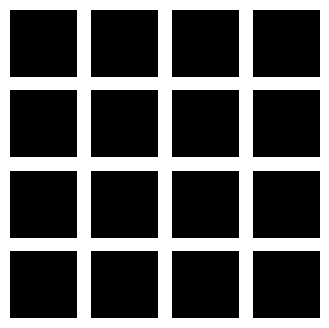

In [79]:
generate_and_save_images(cvae_model, 0, test_sample, "bird_vae_generated")
elbos = []
t = tqdm(range(1, epochs+1))
for epoch in t:
    start = time.time()
    for train_x_img, train_x_label in tqdm(task2_train_dl, leave=False):
        train_step(cvae_model, train_x_img, optimizer)
    
    loss = tf.keras.metrics.Mean()
    for test_x_img, test_x_label in tqdm(task2_val_dl, leave=False):
        loss(compute_loss(cvae_model, test_x_img))
    elbo = -loss.result()
    elbos.append(elbo)
    end = time.time()
    if tf.math.is_nan(elbo):
        for train_x_img, train_x_label in task2_train_dl.take(1):
            print(cvae_model.encode(train_x_img))
    display.clear_output(wait=False)
    print(f'Epoch: {epoch}/{epochs}, Test set ELBO: {elbo}, time elapse for current epoch: {end-start}')
    t.set_description(f"Epoch {epoch}, Val set ELBO: {elbo}, running time: {end-start:.2f}")
    generate_and_save_images(cvae_model, epoch, test_sample, "bird_vae_generated")

In [80]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [81]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [82]:
train_size = 60000
batch_size = 256
test_size = 10000

In [83]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [84]:
class smallCVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(smallCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [85]:
optimizer = tf.keras.optimizers.Adam(1e-3)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [86]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = smallCVAE(latent_dim)

In [87]:
def generate_and_save_images(model, epoch, test_sample, dr="vae_generated"):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}/image_at_epoch_{:04d}.png'.format(dr,epoch))
    plt.show()

In [88]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10/10, Test set ELBO: -189.23524475097656, time elapse for current epoch: 1.844998836517334


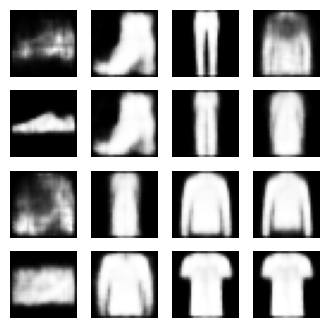

In [89]:
generate_and_save_images(model, 0, test_sample, "fashion_vae_generated")

for epoch in tqdm(range(1, epochs + 1)):
    start_time = time.time()
    for train_x in tqdm(train_dataset, leave=False):
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in tqdm(test_dataset, leave=False):
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}/{}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, epochs, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample, "fashion_vae_generated")

#### Part 2

In [103]:
class GAN():
    def __init__(self):
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            
            tf.keras.layers.Reshape((7,7,256)),
            
            tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            
            tf.keras.layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh")
        ])
        print(self.generator.summary())
        
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[28,28,1]),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1)
        ])
        print(self.discriminator.summary())
    
    def generate(self, x, **kwargs):
        return self.generator(x, **kwargs)
    
    def discriminate(self, x, **kwargs):
        return self.discriminator(x, **kwargs)

In [104]:
gan_model = GAN()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_35 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_36 (Bat  (None, 7, 7, 128)       

In [105]:
noise = tf.random.normal([1,100])

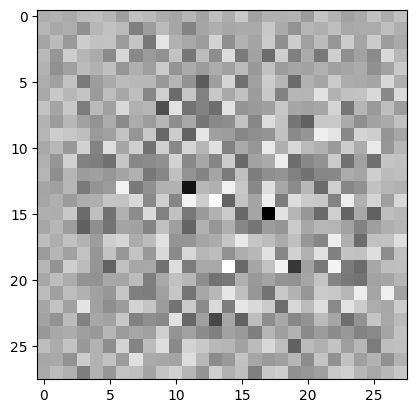

In [106]:
gen_img = gan_model.generate(noise, training=False)
plt.imshow(gen_img[0,:,:,0], cmap="Greys")

In [107]:
gan_model.discriminate(gen_img)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00049592]], dtype=float32)>

In [108]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [109]:
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

In [110]:
gen_opt = tf.keras.optimizers.Adam(1e-4)
dis_opt = tf.keras.optimizers.Adam(1e-4)

In [111]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [112]:
def gan_generate_and_save_images(model, epoch, test_input, dr):
    preds = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(preds.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(preds[i,:,:,0] * 127.5+127.5, cmap="Greys")
        plt.axis("off")
    
    plt.savefig(f"{dr}/image_at_epoch{epoch:04d}.png")
    plt.show()

In [113]:
def train_step(gan_model, images, batch_size, epoch, minimum_gen_loss, minimum_dis_loss, first_gen_epoch, first_dis_epoch):
    noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        gen_imgs = gan_model.generate(noise, training=True)
        
        real_out = gan_model.discriminate(images, training=True)
        fake_out = gan_model.discriminate(gen_imgs, training=True)
        
        gen_loss = generator_loss(fake_out)
        dis_loss = discriminator_loss(real_out, fake_out)
    
    if gen_loss > minimum_gen_loss and epoch >= first_gen_epoch:
        gen_grad = gen_tape.gradient(gen_loss, gan_model.generator.trainable_variables)
        gen_opt.apply_gradients(zip(gen_grad, gan_model.generator.trainable_variables))
    
    if dis_loss > minimum_dis_loss and epoch >= first_dis_epoch:
        dis_grad = dis_tape.gradient(dis_loss, gan_model.discriminator.trainable_variables)
        dis_opt.apply_gradients(zip(dis_grad, gan_model.discriminator.trainable_variables))
    
    return gen_loss, dis_loss

In [114]:
def train(model, dataset, epochs, dr, batch_size, minimum_gen_loss=0, minimum_dis_loss=0, first_gen_epoch=0, first_dis_epoch=0):
    gan_generate_and_save_images(model.generator, 0, seed, dr)
    for epoch in range(epochs):
        start = time.time()
        gs = []
        ds = []
        for image_batch in tqdm(dataset):
            if len(image_batch) == 2:
                image_batch = image_batch[0]
            g,d = train_step(model, image_batch, batch_size, epoch, minimum_gen_loss, minimum_dis_loss, first_gen_epoch, first_dis_epoch)
            gs.append(g)
            ds.append(d)
        display.clear_output(wait=True)
        gan_generate_and_save_images(model.generator, epoch+1, seed, dr)
        
        print(f"Time for epoch {epoch+1}/{epochs} is {time.time() - start:.2f} sec; Generator loss : {sum(gs)/len(gs)}, Discriminator loss : {sum(ds)/len(ds)}")

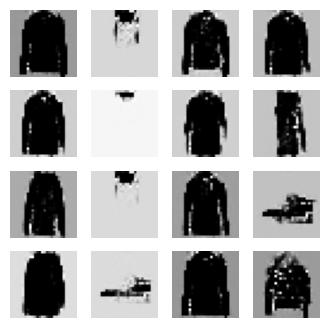

Time for epoch 50/50 is 18.72 sec; Generator loss : 7.371338367462158, Discriminator loss : 0.03698151931166649


In [115]:
train(gan_model, train_dataset, epochs, "fashion_gan_generated", batch_size)

In [116]:
class birdGAN():
    def __init__(self):
        img_width = 224
        latent_dim = 100
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Dense(img_width//8*img_width//8*256, use_bias=False, input_shape=(latent_dim,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            
            tf.keras.layers.Reshape((img_width//8,img_width//8,256)),
            
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(1,1), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            
            tf.keras.layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            
            tf.keras.layers.Conv2DTranspose(16, (5,5), strides=(2,2), padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            
            tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh")
        ], name="Bird_GAN_Generator")
        print(self.generator.summary())
        
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer([224,224,3]),
            tf.keras.layers.GaussianNoise(stddev=0.1),
            tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.Dropout(0.3),
            
            # tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"),
            # tf.keras.layers.LeakyReLU(alpha=0.1),
            # tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1)
        ], name="Bird_GAN_Discriminator")
        print(self.discriminator.summary())
    
    def generate(self, x, **kwargs):
        return self.generator(x, **kwargs)
    
    def discriminate(self, x, **kwargs):
        return self.discriminator(x, **kwargs)

In [117]:
bird_gan = birdGAN()
gen_opt = tf.keras.optimizers.Adam(1e-4)
dis_opt = tf.keras.optimizers.Adam(1e-4)

Model: "Bird_GAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 200704)            20070400  
                                                                 
 batch_normalization_38 (Bat  (None, 200704)           802816    
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 200704)            0         
                                                                 
 reshape_7 (Reshape)         (None, 28, 28, 256)       0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 28, 28, 64)       409600    
 Transpose)                                                      
                                                                 
 batch_normalization_39 (Bat  (None, 28, 28, 64)

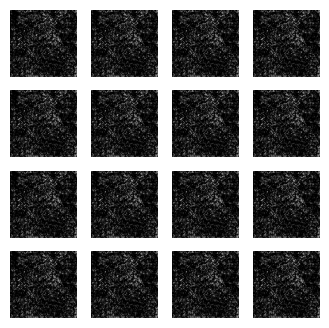

Time for epoch 50/50 is 153.52 sec; Generator loss : 7.154710292816162, Discriminator loss : 0.0008212855900637805


In [118]:
train(bird_gan, task2_train_dl, epochs, "bird_gan_generated", bird_batch_size, minimum_gen_loss=1e-3, minimum_dis_loss=1e-3, first_gen_epoch=0, first_dis_epoch=1)